The spelled-out intro to neural networks and backpropagation: building micrograd


In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def f(x):
    '''
    limits of the function:
    - x can be any real number
    - f(x) can be any real number
    This is a quadratic function (polynomial of degree 2)
    f(x) = 3x^2 - 4x + 5
    '''
    return 3*x**2 - 4*x + 5

In [44]:
f(3.0)

20.0

In [45]:
'''
Create an array of x values from -5 to 5 with steps of 0.25
'''
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

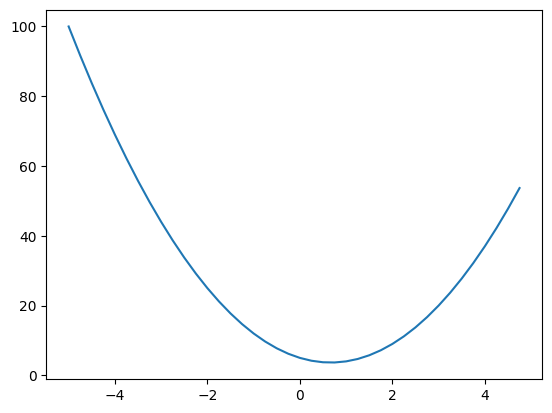

In [46]:
# plot
plt.plot(xs, ys)
''' 
The plot will show a parabola, which is the graph of the quadratic function f(x) = 3x^2 - 4x + 5.
The parabola opens upwards because the coefficient of x^2 (which is 3) is positive.
The vertex of the parabola is the point where the function reaches its minimum value.
The vertex is at the point (4/3, -1/3), which is the point where the function changes direction.
'''
plt.show()



In [47]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h


2.999378523327323e-06

In [48]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d


4.0

In [49]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# outputs

"""
This code implements numerical differentiation using the finite difference method:
1. d1 represents f(x)
2. d2 represents f(x + h)
3. The derivative can then be approximated as: (d2 - d1)/h

This is known as the forward difference formula:
f'(x) ≈ [f(x + h) - f(x)] / h

The smaller the value of h, the more accurate the approximation,
but too small values can lead to numerical precision issues.
"""
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1) 
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [50]:
class Value:
    '''
    This class represents a single value in a neural network.
    Basic implementation that only stores data
    It can be used to represent a scalar value or a vector value.
    '''
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
a = Value(2.0)
a


Value(data=2.0)

In [51]:
class Value:
    '''
    Enhanced Value class that implements automatic differentiation
    This version adds support for addition operations 
    '''
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
a = Value(2.0)
b = Value(-3.0)
a + b


Value(data=-1.0)

In [52]:
class Value:
    '''
    Supports both addition and multiplication
    '''
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b + c


Value(data=4.0)

In [79]:
class Value:
    '''
    A class that implements a basic autograd engine for scalar values.
    
    This class tracks computations on scalar values and enables automatic
    differentiation by building a computation graph. Each Value instance
    represents a node in this graph.

    Attributes:
        data: The scalar value stored in this node
        _prev: Set of Value objects that were used to compute this value (children)
        _op: String indicating the operation that produced this value (e.g., '+', '*')
        label: Optional label for visualization purposes

    Supported Operations:
        - Addition (via __add__)
        - Multiplication (via __mul__)
    
    Example:
        a = Value(2.0, label='a')
        b = Value(3.0, label='b')
        c = a * b  # Creates new Value with operation '*' and children (a, b)
    '''
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


Value(data=-8.0)

In [56]:
d._prev


{Value(data=-6.0), Value(data=10.0)}

In [58]:
d._op


'+'

In [82]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

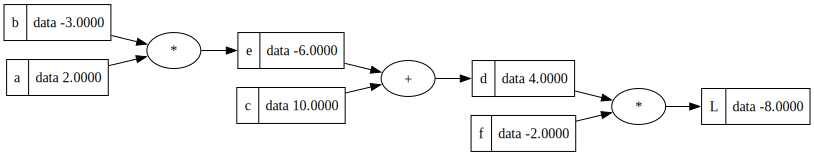

In [83]:
draw_dot(L)

Forward pass done. ^

In [231]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
       self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


Value(data=-8.0)

In [94]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

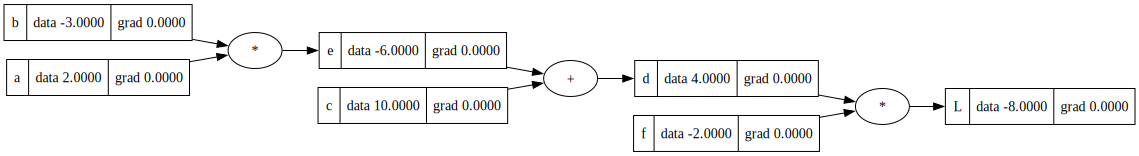

In [100]:
draw_dot(L)

key blocks to understand backprop and training nn: 

The Chain Rule is a fundamental concept in calculus that tells us how to compute the derivative of a composite function. In the context of your neural network implementation, it's essential for backpropagation.

Here's a simple explanation:

1. **Basic Chain Rule**
If you have a composite function h(x) = f(g(x)), then:
```
h'(x) = f'(g(x)) * g'(x)
```

2. **In Your Code's Context**
Looking at your computation graph:
```
a → e → d → L
b ↗   ↗   ↘
    c     f
```

Let's break down how the chain rule applies:

- To find ∂L/∂a (how L changes with respect to a), we need to multiply all the derivatives along the path from L to a:
```
∂L/∂a = ∂L/∂d * ∂d/∂e * ∂e/∂a
```

3. **Example with Values**
In your code:
```python
L = d * f     # L = d * f
d = e + c     # d = (a * b) + c
e = a * b     # e = a * b
```

If we want to find ∂L/∂b:
```
∂L/∂b = ∂L/∂d * ∂d/∂e * ∂e/∂b
      = f * 1 * a
```

This is why in backpropagation:
1. We start at the end (L)
2. Set the gradient of L to 1.0 (L.grad = 1.0)
3. Work backwards, multiplying gradients along the way
4. Each node accumulates gradients from all paths that lead to it

This is exactly what your code in cell 24 is numerically verifying using finite differences (h = 0.001) to approximate these derivatives.


manually backprop:

In [120]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


In [107]:
L.grad = 1.0

L = d * f

dL / dd =? f
why? 
(f(x+h) - f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h
h*f/h
f


In [111]:
f.grad = 4.0 # is the value of d, which is 4
d.grad = -2.0 # is the value of f, which is -2

Understand the gradient of this node, understand backprop and training nn:

dd / dc = ? 1.0

d = c + e

(f(x+h) - f(x))/h
((c+h + e) - (c + e))/h
(c + h + e - c - e)/h
h/h
1.0

dd / de = ? 1.0 by default (its the 'local' derivative)


want
dL / dc

know
dL / dd
dd / dc

so
dL / dc = (dL / dd) * (dd / dc)




! what the + node does is literally just routes the gradient. 

In [114]:
c.grad = -2.0
e.grad = -2.0 # by simetry

know
dL / de = -2.0

want
dL / da =?
de / da =? b

so
dL / da = (dL / de) * (de / da)


In [117]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0


In [255]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

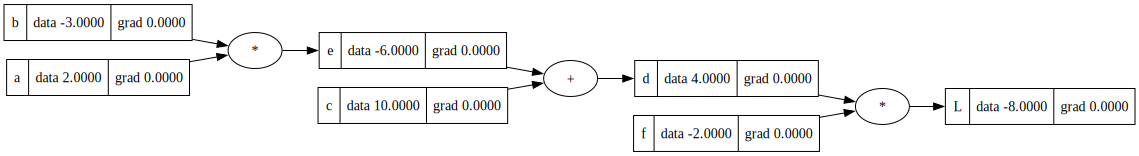

In [170]:
draw_dot(L)

backprop is done. (backpropagation is recursive application of chain rule!)


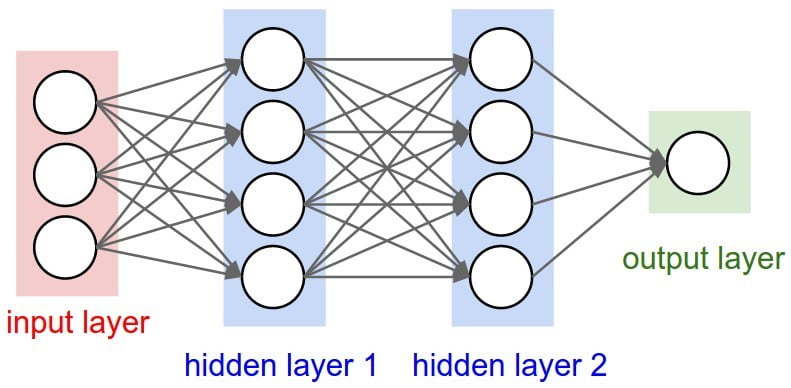

In [121]:
from IPython.display import Image
Image('micrograd/nn.png')

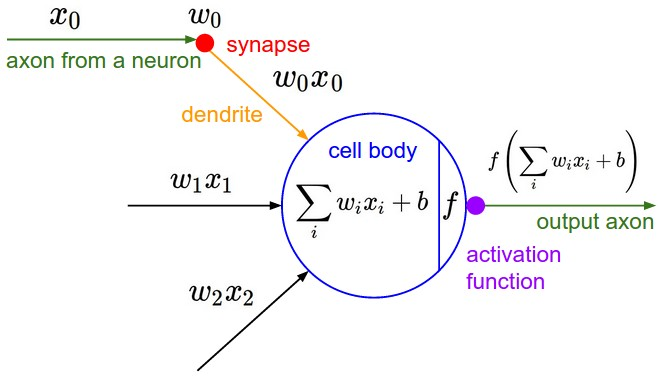

In [122]:
Image('micrograd/wb.jpeg')


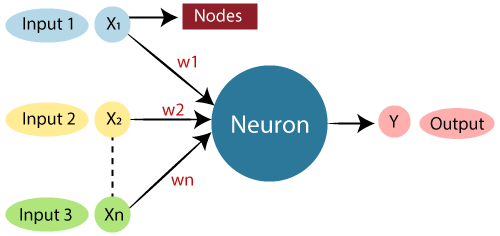

In [156]:
Image('micrograd/ann.png')

In [123]:
"""
a basic gradient descent optimization step:

1. Update Parameters:
   - Each variable (a, b, c, f) is updated using the formula: 
     param = param + learning_rate * gradient
   - Learning rate is set to 0.01
   - The gradients (stored in .grad) were computed via backpropagation

2. Forward Pass:
   - Recompute the forward pass with updated parameters
   - e = a * b
   - d = e + c
   - L = d * f

3. Print Result:
   - Shows the new loss value after one optimization step
   - If loss decreases, the optimization step was successful

This is one iteration of gradient descent, attempting to minimize the loss L
by adjusting the parameters in the direction that reduces the loss.
"""

# Gradient descent step (learning_rate = 0.01)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Recompute forward pass with updated parameters
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [134]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


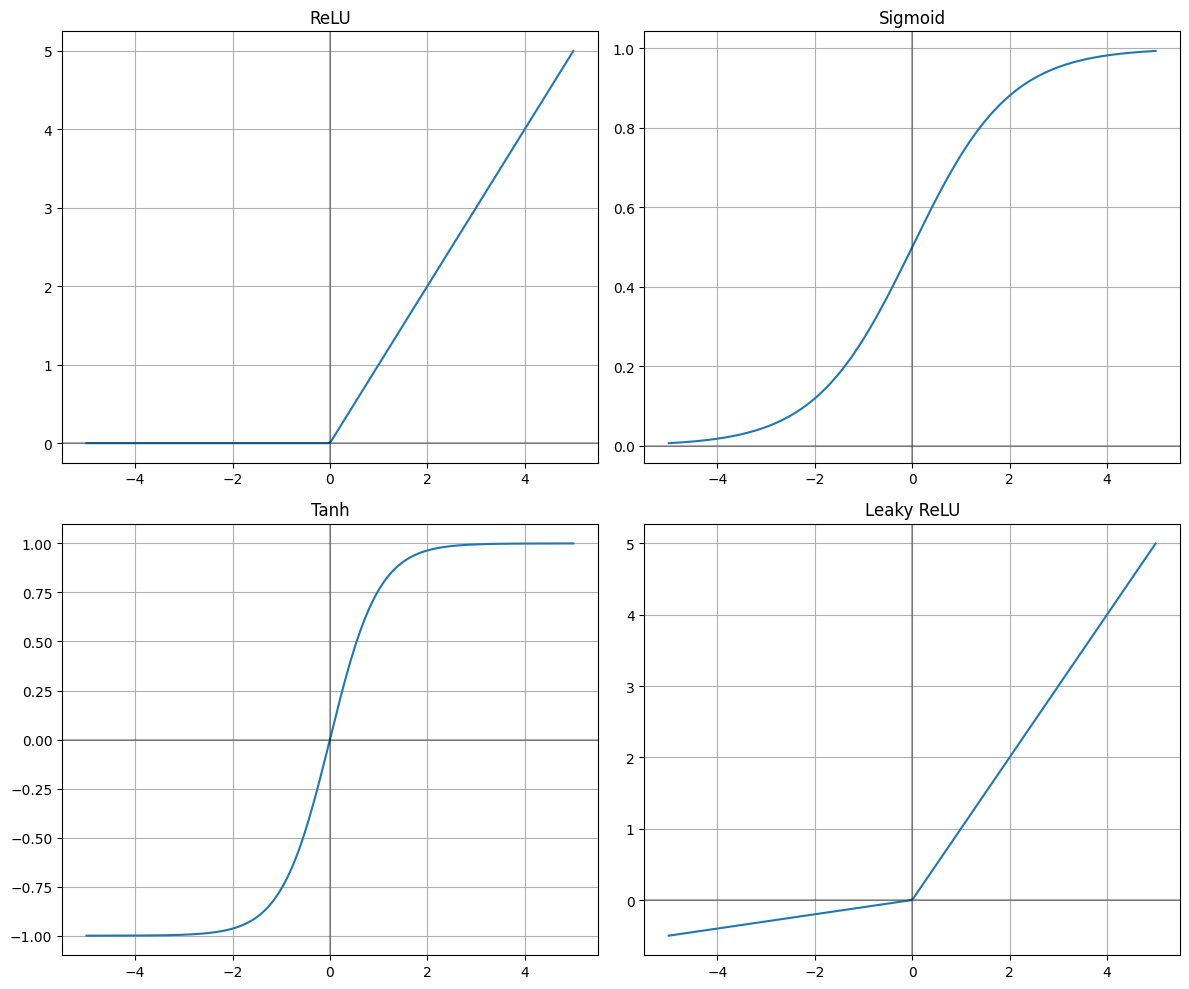

In [127]:
#Common activation functions:

import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(-5, 5, 200)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. ReLU (Rectified Linear Unit)
def relu(x):
    return np.maximum(0, x)

ax1.plot(x, relu(x))
ax1.set_title('ReLU')
ax1.grid(True)
ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 2. Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ax2.plot(x, sigmoid(x))
ax2.set_title('Sigmoid')
ax2.grid(True)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 3. Tanh
ax3.plot(x, np.tanh(x))
ax3.set_title('Tanh')
ax3.grid(True)
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 4. Leaky ReLU
def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

ax4.plot(x, leaky_relu(x))
ax4.set_title('Leaky ReLU')
ax4.grid(True)
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax4.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

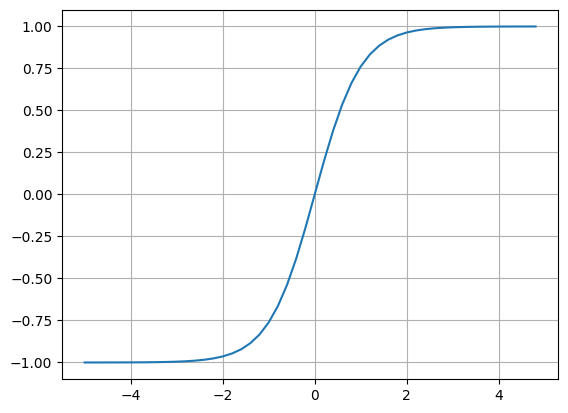

In [135]:
"""
the hyperbolic tangent (tanh) activation function.

Key characteristics of tanh:
1. Output range: [-1, 1]
2. S-shaped curve (sigmoid-like)
3. Symmetric around the origin (0,0)
4. Steepest gradient at x=0
5. Approaches asymptotes at y=1 and y=-1

The plot shows:
- x-axis: input values from -5 to 5 in steps of 0.2
- y-axis: corresponding tanh output values
"""

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [257]:
"""
a single neuron in a neural network with:
- 2 inputs (x1, x2)
- 2 weights (w1, w2)
- 1 bias (b)
- tanh activation function

The computation follows these steps:
1. Input Layer:
   - x1: First input value (2.0)
   - x2: Second input value (0.0)

2. Weights and Bias:
   - w1: Weight for first input (-3.0)
   - w2: Weight for second input (1.0)
   - b: Bias term (6.8813...)

3. Neuron Computation:
   - First multiply inputs by weights: x1*w1 and x2*w2
   - Sum the products: (x1*w1 + x2*w2)
   - Add bias: n = (x1*w1 + x2*w2 + b)
   - Apply activation: o = tanh(n)

This represents a basic feedforward computation in a neural network,
where the neuron takes inputs, applies weights and bias, 
and transforms the result using an activation function.
"""

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # o = output


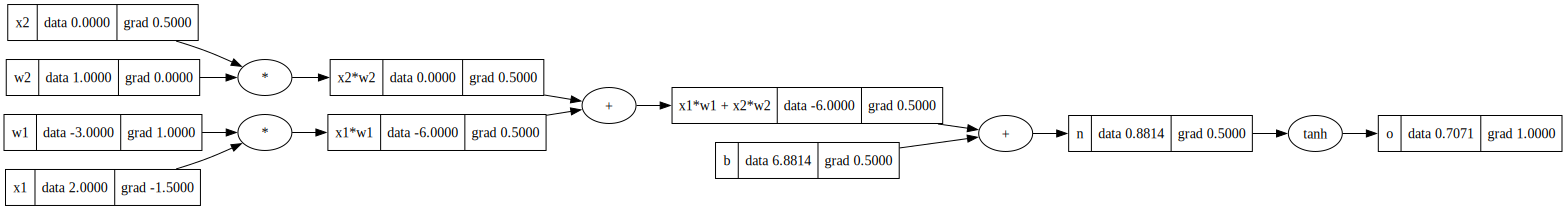

In [266]:
draw_dot(o)

In [151]:
# update class Value with tanh

def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

2nd example of backprop:

In [154]:
o.grad = 1.0

o = o.tanh(n)
do/dn = 1 - o.data**2


In [157]:
1 - o.data**2

0.4999999999999999

In [158]:
n.grad = 0.5

note: once again we have + operation, which routes the gradient.  (n.grad = 0.5)

In [160]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [162]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [164]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


In [166]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


now, once we completed the manual backprop, lets create an automatic backprop. Go to the class Value and add the backward function. 


In [259]:
o.grad = 1.0


In [260]:
o._backward()

In [261]:
n._backward()

In [262]:
b._backward()

In [263]:
x1w1x2w2._backward()

In [264]:
x2w2._backward()


In [265]:
x1w1._backward()